## ✅KAGGLE 자전거 수요예측_DACON 서울시따릉이 

### ❗진행과정

**1. Import & Data chk**

**2. Data Preprocessing & EDA**

**3. Feature Engineering**

**4. Modeling**

### 1️⃣Import & Data chk

> * **데이터 정보 확인**

> * **결측치 확인**

> * **이상치 확인**

> * **왜도/첨도 확인**

In [59]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy import stats
from collections import Counter

import missingno as msno
plt.style.use('seaborn')

import warnings 
warnings.filterwarnings("ignore")

mpl.rcParams['axes.unicode_minus'] =False

%matplotlib inline

In [60]:
df_train = pd.read_csv('../data/train_trans.csv')
df_test = pd.read_csv('../data/test_trans.csv')

###   1) 데이터 정보 확인

In [61]:
#데이터 형상정보 확인( Sample, Feature증심으로)
df_train.head()

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,count
0,3,20,16.3,1.0,1.5,89.0,576.0,0.027,76.0,33.0,49.0
1,6,13,20.1,0.0,1.4,48.0,916.0,0.042,73.0,40.0,159.0
2,7,6,13.9,0.0,0.7,79.0,1382.0,0.033,32.0,19.0,26.0
3,8,23,8.1,0.0,2.7,54.0,946.0,0.040,75.0,64.0,57.0
4,9,18,29.5,0.0,4.8,7.0,2000.0,0.057,27.0,11.0,431.0


In [62]:
df_train.shape

(1459, 11)

In [63]:
#Feature 확인
df_train.columns

Index(['id', 'hour', 'hour_bef_temperature', 'hour_bef_precipitation',
       'hour_bef_windspeed', 'hour_bef_humidity', 'hour_bef_visibility',
       'hour_bef_ozone', 'hour_bef_pm10', 'hour_bef_pm2.5', 'count'],
      dtype='object')

### 결측치 확인

In [64]:
#info()사용해 전체 Feature의 결측치 갯수 확인
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      1459 non-null   int64  
 1   hour                    1459 non-null   int64  
 2   hour_bef_temperature    1457 non-null   float64
 3   hour_bef_precipitation  1457 non-null   float64
 4   hour_bef_windspeed      1450 non-null   float64
 5   hour_bef_humidity       1457 non-null   float64
 6   hour_bef_visibility     1457 non-null   float64
 7   hour_bef_ozone          1383 non-null   float64
 8   hour_bef_pm10           1369 non-null   float64
 9   hour_bef_pm2.5          1342 non-null   float64
 10  count                   1459 non-null   float64
dtypes: float64(9), int64(2)
memory usage: 125.5 KB


### ❗결측치 처리 방법

1. 10% 미만 = row 삭제 or 치환(평균,최빈값 등)
2. 10 ~ 50% = 모델 만들어서 처리
3. 50% 이상 = col 삭제

In [65]:
#결측치 비율 확인
for col in df_train.columns:
    msperc = 'column : {:>10}\t Percent of NaN value: {: .2f}'.format(col,
                    100 * (df_train[col].isnull().sum() / df_train[col].shape[0]))
    print(msperc)

column :         id	 Percent of NaN value:  0.00
column :       hour	 Percent of NaN value:  0.00
column : hour_bef_temperature	 Percent of NaN value:  0.14
column : hour_bef_precipitation	 Percent of NaN value:  0.14
column : hour_bef_windspeed	 Percent of NaN value:  0.62
column : hour_bef_humidity	 Percent of NaN value:  0.14
column : hour_bef_visibility	 Percent of NaN value:  0.14
column : hour_bef_ozone	 Percent of NaN value:  5.21
column : hour_bef_pm10	 Percent of NaN value:  6.17
column : hour_bef_pm2.5	 Percent of NaN value:  8.02
column :      count	 Percent of NaN value:  0.00


<AxesSubplot:>

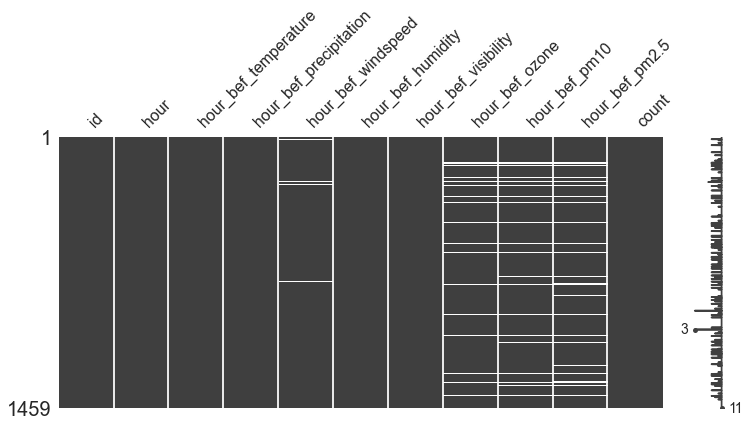

In [66]:
#결측치 시각화
msno.matrix(df_train, figsize=(12,5))

### 📝hour_bef_ozone, hour_bef_pm10, hour_bef_pm2.5에서 결측치 비율이 높은것을 확인

### 이상치 확인

> * **백분위수 기반으로 이상치 제거하는 detect_outliers 함수 정의** 

In [67]:
def detect_outliers(df, n, features):
    outlier_indices = []
    for col in features:
        Q1 = np.percentile(df[col], 25)
        Q3 = np.percentile(df[col], 75)
        IQR = Q3 - Q1
        
        outlier_step = 1.5 * IQR
        
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step)].index
        outlier_indices.extend(outlier_list_col)
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list(k for k, v in outlier_indices.items() if v > n)
        
    return multiple_outliers

In [68]:
Outliers_to_drop = detect_outliers(df_train, 2,
        ['id','hour', 'hour_bef_temperature', 'hour_bef_precipitation',
       'hour_bef_windspeed', 'hour_bef_humidity', 'hour_bef_visibility',
       'hour_bef_ozone', 'hour_bef_pm10', 'hour_bef_pm2.5'])

In [69]:
df_train.loc[Outliers_to_drop]

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,count


### 📝이상치 없음

### 2️⃣데이터 전처리 및 EDA(데이터 시각화)

> * **시간, 온도, 강수량이 대여량에 영향을 미칠것으로 추측**

**데이터 분포 확인 위해 KDE그래프 시각화(히스토그램 대안)**

<AxesSubplot:xlabel='count', ylabel='Density'>

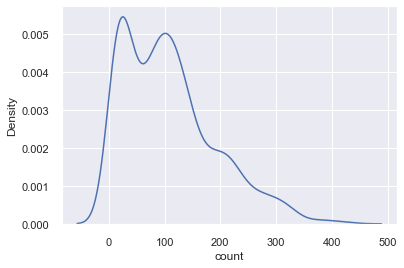

In [99]:
sns.kdeplot(df_train['count'])

**시간별 대여량 파악을 위해 barplot 시각화**

<AxesSubplot:xlabel='hour', ylabel='count'>

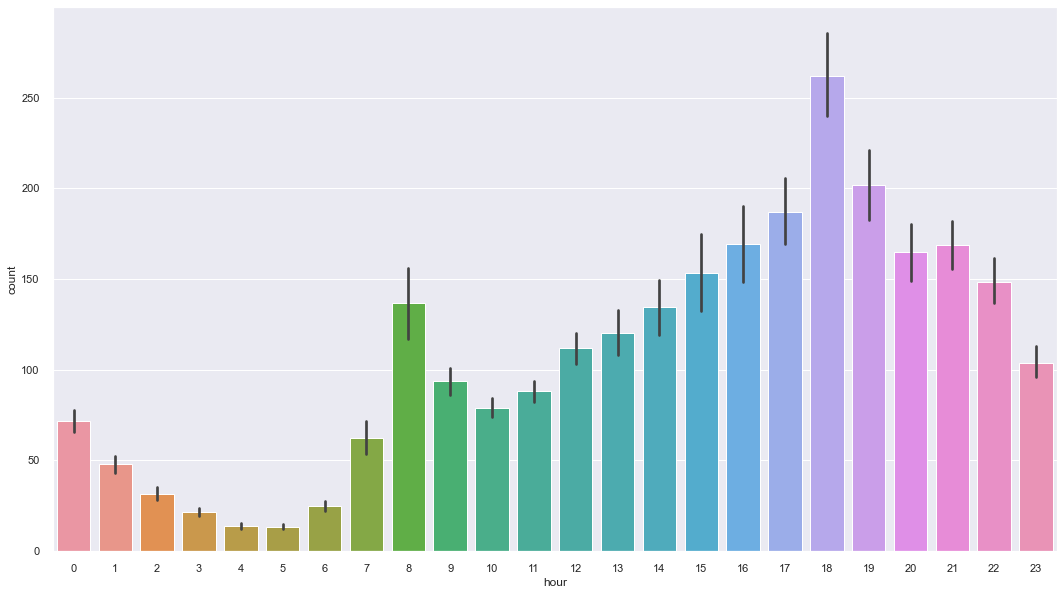

In [100]:
figure, ax1 = plt.subplots(nrows=1, ncols=1)
figure.set_size_inches(18, 10)

sns.barplot(data=df_train, x="hour", y="count", ax=ax1)

### 📝오후 18시에 대여량 높음 = 출퇴근 시간 고려

**특성들 간의 상관관계를 파악하기 위해 heatmap 시각화**

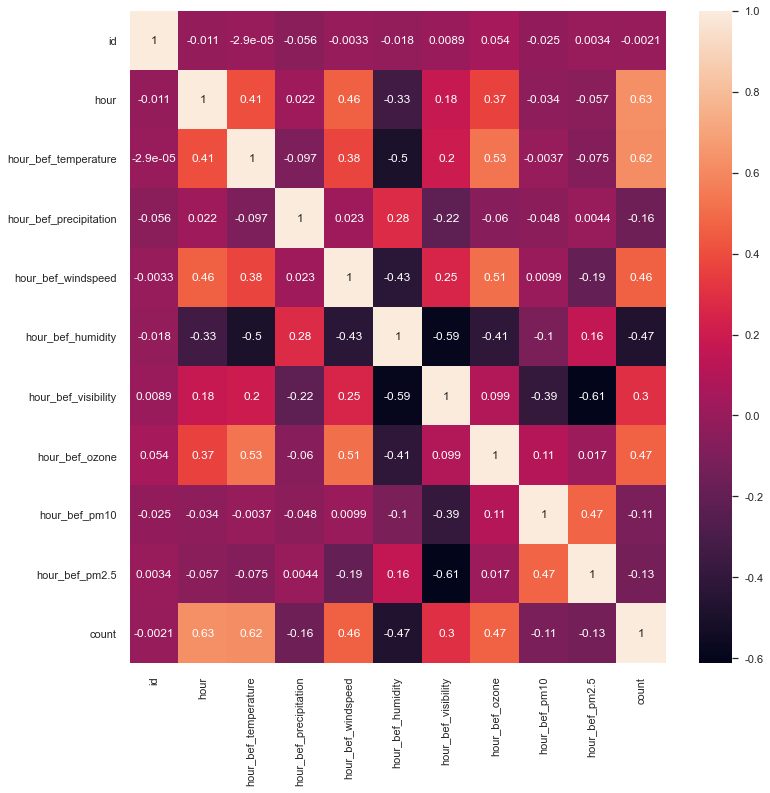

In [101]:
#특성들 간의 상관관계를 heatmap을 통해 시각화
fig = plt.figure(figsize=[12,12])
ax = sns.heatmap(df_train.corr(), annot=True)

### 📝시간,온도 count에는 양의 상관이 있음

### pairplot을 통해 특성들 간의 상관관계를 산포도로 시각화

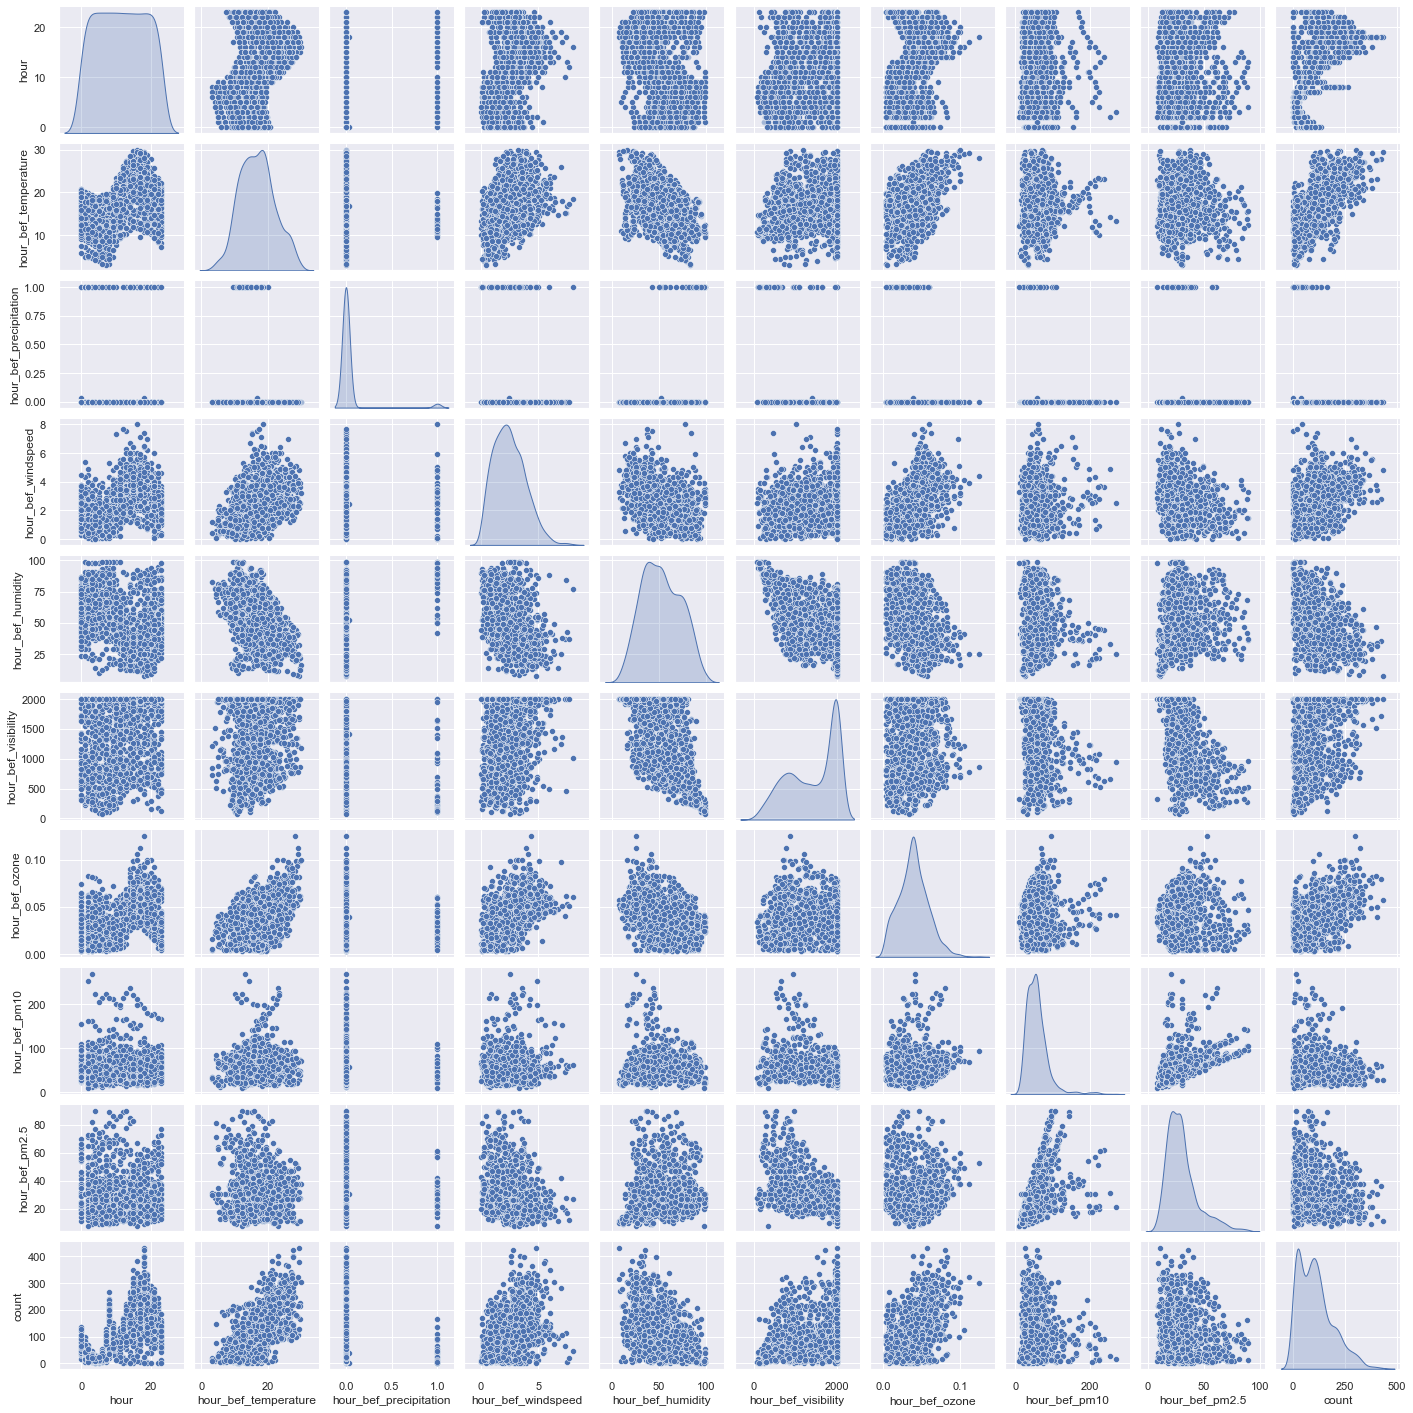

In [102]:
# pairplot을 통해 특성들 간의 상관관계를 산포도로 시각화
sns.set()
columns = ['hour', 'hour_bef_temperature', 'hour_bef_precipitation',
       'hour_bef_windspeed', 'hour_bef_humidity', 'hour_bef_visibility',
       'hour_bef_ozone', 'hour_bef_pm10', 'hour_bef_pm2.5', 'count']

sns.pairplot(df_train[columns],size = 2 ,kind ='scatter',diag_kind='kde')
plt.show()

### 강수량과 풍속에 대해 Scatterplot 시각화

<AxesSubplot:xlabel='hour_bef_windspeed', ylabel='count'>

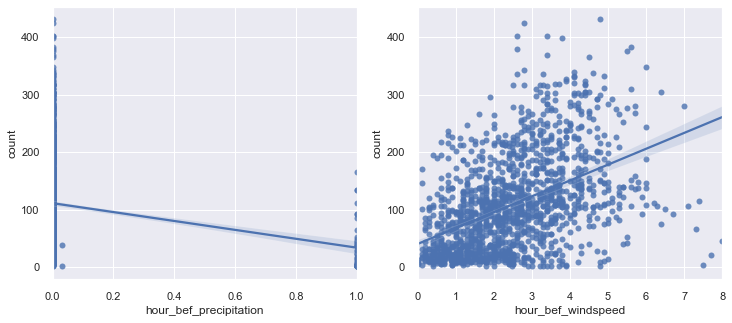

In [103]:
#heatmap을 통해 무의미하다고 판단된 feature에 대해 Scatterplot 시각화
#강수량의 경우 대부분의 데이터가 0에 분포 --> 강수량이 0인 경우가 드물기 때문에 null데이터를 0으로 대체한게 아닌가 추측
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize=(12,5)) 

temp_scatter_plot = pd.concat([df_train['count'],df_train['hour_bef_precipitation']],axis = 1) 
sns.regplot(x='hour_bef_precipitation',y = 'count',data = temp_scatter_plot,scatter= True, fit_reg=True, ax=ax1) 
windspeed_scatter_plot = pd.concat([df_train['count'],df_train['hour_bef_windspeed']],axis = 1) 
sns.regplot(x='hour_bef_windspeed',y = 'count',data = windspeed_scatter_plot,scatter= True, fit_reg=True, ax=ax2)

### 결측치 처리

In [104]:
#결측치 있는 특성 확인
train_isna_sum = df_train.isna().sum()
train_isna_sum

id                        0
hour                      0
hour_bef_temperature      0
hour_bef_precipitation    0
hour_bef_windspeed        0
hour_bef_humidity         0
hour_bef_visibility       0
hour_bef_ozone            0
hour_bef_pm10             0
hour_bef_pm2.5            0
count                     0
dtype: int64

In [105]:
train_isna_sum[train_isna_sum != 0].index

Index([], dtype='object')

In [106]:
na_col = train_isna_sum[train_isna_sum != 0].index

### fill_bicycle_na, 결측치 처리 함수 정의

In [107]:
#train 데이터셋 결측치 처리
def fill_bicycle_na(df, column):
    df[column] = df[column].fillna(df[column].mean())

In [108]:
for col in na_col:
    fill_bicycle_na(df_train, col)
    print(col, '결측값 대체 완료')

In [109]:
#test 데이터셋 결측치 처리
test_isna_sum = df_test.isna().sum()

In [110]:
test_na_columns = test_isna_sum[test_isna_sum != 0].index

In [111]:
for col in test_na_columns:
    fill_bicycle_na(df_test, col)
    print(col, '대체 완료')

In [112]:
df_test.isna().sum()

id                        0
hour                      0
hour_bef_temperature      0
hour_bef_precipitation    0
hour_bef_windspeed        0
hour_bef_humidity         0
hour_bef_visibility       0
hour_bef_ozone            0
hour_bef_pm10             0
hour_bef_pm2.5            0
dtype: int64

### 3️⃣Feature Engineering
> * 왜도 첨도 확인

> * 표준화

Skewness: 0.912534
Kurtosis: 0.460328


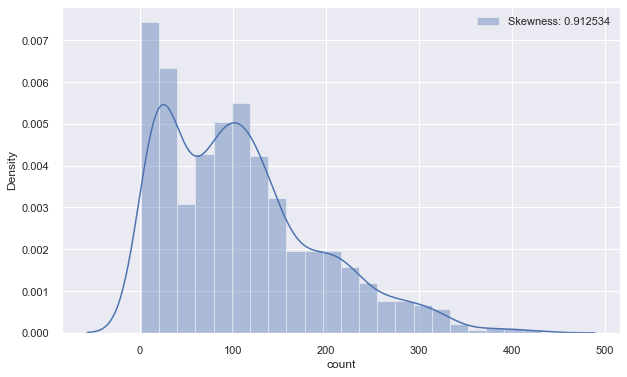

In [113]:
# 튜닝하기 전에 레이블 클래스의 첨도와 왜도 확인 --> 데이터의 분포 확인
# 왜도 : 0을 기준 // 첨도 : 3을 기준 
# 모델에 사용되는 모든 변수들은 왜도와 첨도를 확인하는 것이 좋음
f, ax = plt.subplots(1, 1, figsize = (10,6))
g = sns.distplot(df_train["count"], color = "b", label="Skewness: {:2f}".format(df_train["count"].skew()), ax=ax) 
g = g.legend(loc = "best") 

print("Skewness: %f" % df_train["count"].skew()) 
print("Kurtosis: %f" % df_train["count"].kurt())

Skewness: -1.014012
Kurtosis: 0.936030


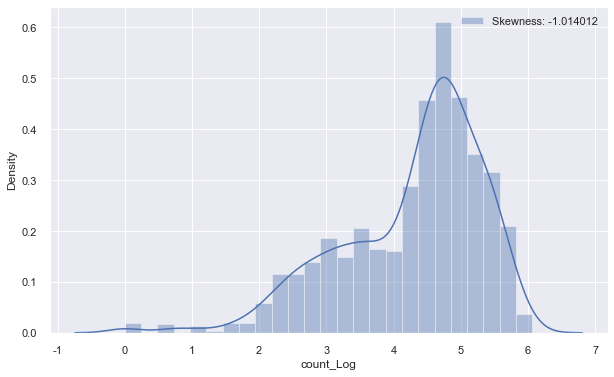

In [114]:
#로그정규분포 통해 target변수 튜닝
# why? 로그정규분포 변수는 항상 '양수'값 가짐 --> 정규분포가 음수값을 가지는 것에 대한 해결책이 될 수 있음
df_train["count_Log"] = df_train["count"].map(lambda i:np.log(i) if i>0 else 0)

f, ax = plt.subplots(1, 1, figsize = (10,6)) 
g = sns.distplot(df_train["count_Log"], color = "b", label="Skewness: {:2f}".format(df_train["count_Log"].skew()), ax=ax) 
g = g.legend(loc = "best") 

print("Skewness: %f" % df_train['count_Log'].skew()) 
print("Kurtosis: %f" % df_train['count_Log'].kurt()) 

df_train.drop('count', axis= 1, inplace=True)

### 4️⃣Modeling
> * **sklearn의 GradientBoostingRegressor**

> * **학습을 위해 train_test_split을 통해 데이터 셋을 학습용과 검증용으로 구분**

> * **클래스 레이블인 count_Log를 제외한 나머지 feature들을 X_train에, count_Log의 값을 target_label에 저장**

>*  **X_tr, X_vld, y_tr, y_vld = 훈련 데이터, 테스트 데이터, 훈련 레이블, 테스트 레이블**

In [115]:
from sklearn.model_selection import train_test_split
from sklearn import metrics

X_train=df_train.drop("count_Log",axis=1).values
target_label=df_train["count_Log"].values
X_test=df_test.values
X_tr, X_vld, y_tr, y_vld = train_test_split(X_train, target_label, test_size=0.2, random_state=2000)

In [116]:
from sklearn.ensemble import GradientBoostingRegressor 
regressor = GradientBoostingRegressor(n_estimators=2000, learning_rate=0.05, 
                                      max_depth=4, min_samples_leaf=15, 
                                      min_samples_split=10, random_state =42) 

regressor.fit(X_tr,y_tr)

GradientBoostingRegressor(learning_rate=0.05, max_depth=4, min_samples_leaf=15,
                          min_samples_split=10, n_estimators=2000,
                          random_state=42)

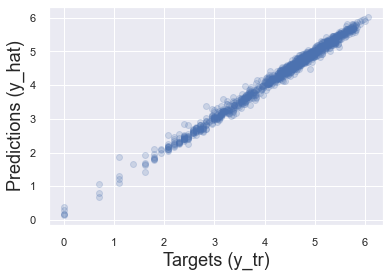

In [117]:
y_hat = regressor.predict(X_tr) 
plt.scatter(y_tr, y_hat, alpha = 0.2) 
plt.xlabel('Targets (y_tr)',size=18) 
plt.ylabel('Predictions (y_hat)',size=18) 
plt.show()

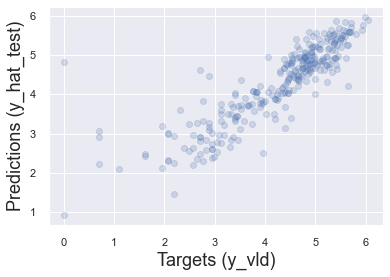

In [118]:
y_hat_test = regressor.predict(X_vld) 
plt.scatter(y_vld, y_hat_test, alpha=0.2) 
plt.xlabel('Targets (y_vld)',size=18) 
plt.ylabel('Predictions (y_hat_test)',size=18) 
plt.show()

### 사이킷런의 교차검증을 활용해 모델 평가

In [123]:
from sklearn.model_selection import cross_val_score 
accuracies = cross_val_score(estimator = regressor, X = X_tr, y = y_tr, cv = 8)

In [124]:
print(accuracies.mean()) 
print(accuracies.std())

0.73551281966842
0.0781655403039464
